### This notebook is stale - master is on WML

Git Repo: https://github.ibm.com/wiotp/monitoring-dashboard


In [1]:
import csv
import requests
import collections
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [2]:
from mmfunctions import gitanalyzer

In [3]:
params = {}
params['REPO'] = 'wiotp/monitoring-dashboard'
params['REPO2'] = 'wiotp/analytics-service'
params['REPO_ID'] = 566611
params['REPO2_ID'] = 211664
params['ZENHUB_WORKSPACE'] = '5cd44ce4baded506ba8ddd5f'
params['GITHUB_TOKEN'] = 'ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab'
params['ZENHUB_TOKEN'] = '814960f27921de182e39873816e4a54be9cdbb5000baa92d054e773949c1681e5e637c3bd30b54ad'
params['TRAVIS_TOKEN'] = '7B8mnG99oqNcHJgKKXMYVQ'
params['BASE_URL'] = 'https://github.ibm.com'
gitanalyzer.process_all(params)


GET https://zenhub.ibm.com/p2/workspaces/5cd44ce4baded506ba8ddd5f/repositories/566611/board
  : => 200
GET https://zenhub.ibm.com/p2/workspaces/5cd44ce4baded506ba8ddd5f/repositories/211664/board
  : => 200
GET https://github.ibm.com/api/v3/repos/wiotp/monitoring-dashboard/issues
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=all&page=2
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=all&page=3
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=all&page=4
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=all&page=5
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=all&page=6
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/566611/issues?is=issue&state=all&page=7


  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=36
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=37
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=38
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=39
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=40
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=41
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=42
  : => 200
  : Writing 30 issues
GET https://github.ibm.com/api/v3/repositories/211664/issues?is=issue&state=all&page=43
  : => 200
  : Writing 30 issues

In [4]:
# upload stuff for later use to COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
put monitoring-defects.csv s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in

upload: 'monitoring-defects.csv' -> 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv'  [1 of 1]
 693365 of 693365   100% in    3s   190.48 kB/s  done


In [5]:
# get it back from COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --force --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
get s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv wiotp-monitoring-dashboard-defects.csv

download: 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv' -> 'wiotp-monitoring-dashboard-defects.csv'  [1 of 1]
 693365 of 693365   100% in    2s   245.02 kB/s  done


In [6]:
defects_df = pd.read_csv('./wiotp-monitoring-dashboard-defects.csv') # parse_dates=['Created'])

## Remove the encoding prefix string
df=defects_df.replace('b\'','',regex=True).astype(object)
df=df.replace('b\"','',regex=True).astype(object)
df['Created'] = pd.to_datetime(df['Created'])
df['Updated'] = pd.to_datetime(df['Updated'])
df['Closed'] = pd.to_datetime(df['Closed'])

df = df[df['Pipeline'] != 'To Be Closed']
df.head(3)

,Title,Repo,Created,Updated,Closed,Origin,Assignee,Status,Milestone,Type,Component,BusinessValue,Severity,Risk,Theme,Blocked,Pipeline,Labels
937,Integrate doc and test Shell thermal model and...,wiotp/monitoring-dashboard,2020-04-08 10:42:10,2020-04-08 10:52:31,NaT,Carlos-Ferreira1,rsiva,open,NaN,Bug,Monitoring,4,3,2,NaN,NaN,New Issues,"['Customer-Shell', 'Epic', 'Squad: Monitoring'..."
936,Admin installs a solution package from Digital...,wiotp/monitoring-dashboard,2020-04-08 10:42:04,2020-04-08 10:58:55,NaT,Carlos-Ferreira1,NaN,open,NaN,Epic,NaN,4,3,2,NaN,NaN,New Issues,"['Customer-Shell', 'Epic']"
935,Dashboard editor,wiotp/monitoring-dashboard,2020-04-08 08:58:40,2020-04-08 09:12:50,2020-04-08 09:12:50,markus-mueller,NaN,closed,NaN,Epic,NaN,4,3,2,NaN,NaN,NaN,['Epic']


In [7]:
#invent severities
df['Severity'] = np.random.choice([1,2,3,4], df.index.size, p = [0.1,0.4,0.3,0.2])
df.head(3)

,Title,Repo,Created,Updated,Closed,Origin,Assignee,Status,Milestone,Type,Component,BusinessValue,Severity,Risk,Theme,Blocked,Pipeline,Labels
937,Integrate doc and test Shell thermal model and...,wiotp/monitoring-dashboard,2020-04-08 10:42:10,2020-04-08 10:52:31,NaT,Carlos-Ferreira1,rsiva,open,NaN,Bug,Monitoring,4,2,2,NaN,NaN,New Issues,"['Customer-Shell', 'Epic', 'Squad: Monitoring'..."
936,Admin installs a solution package from Digital...,wiotp/monitoring-dashboard,2020-04-08 10:42:04,2020-04-08 10:58:55,NaT,Carlos-Ferreira1,NaN,open,NaN,Epic,NaN,4,2,2,NaN,NaN,New Issues,"['Customer-Shell', 'Epic']"
935,Dashboard editor,wiotp/monitoring-dashboard,2020-04-08 08:58:40,2020-04-08 09:12:50,2020-04-08 09:12:50,markus-mueller,NaN,closed,NaN,Epic,NaN,4,3,2,NaN,NaN,NaN,['Epic']


In [8]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def f(severity):
    dfs = df
    if severity > 0:
        dfs = df[df['Severity'] == severity]
    cnt = dfs.groupby('Type')['Title'].count()
    labels = cnt.index
    sizes = cnt.values
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=(0.04, 0, 0), labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('Monitoring issues by type')

#plt.show()
interact(f, severity=[('sev1', 1), ('sev2', 2), ('sev3',3), ('sev4',4), ('all', 0)]);

interactive(children=(Dropdown(description='severity', options=(('sev1', 1), ('sev2', 2), ('sev3', 3), ('sev4'…

### Velocities

- Overall Velocity
- Defect Velocity (**implemented** - starting mid 2019)
- Customer satisfaction (**no data** not included as we have no data)
- Defect breakdown by severity (**no data** we have no severities in our defects)
- Value per sprint (**no data** value of epics or stories is not known)
- Percentage of test case coverage (**no data** - we do not track that)
- Customer Support Requests (**no data*)
- Trends (let's define what trends we need)
- NPS (**no data**)
- Build failures (need to get Travis data)
- Deployment failures (Jenkins ?)
- Technical Debts (**no data** we need a label)

In [9]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


df_velocity = df.copy()
df_velocity = df_velocity[df_velocity['Status'] == 'closed']
df_velocity = df_velocity[df_velocity['Created'] > StartWith]
df_velocity['Age_in_weeks'] = df_velocity['Closed'] - df_velocity['Created'] + pd.Timestamp('2020-01-01')
df_velocity = df_velocity[['Severity', 'Age_in_weeks']]


def f(severity):
    df_vel = df_velocity.copy()
    if severity != 0:
        df_vel = df_vel[df_vel['Severity'] == severity]
    df_vel = df_vel[['Age_in_weeks']]
    #df_vel.groupby([df_vel["Age"].dt.year,
    #              df_vel["Age"].dt.month, df_vel["Age"].dt.week]).count().plot(figsize=(10,8), kind="bar", title='Defect velocity by weeks')
    df_vel.groupby(df_vel['Age_in_weeks'].dt.week).count().plot(figsize=(7,5), kind='bar', legend=False)
    ax1 = plt.axes()
    x_axis = ax1.axes.get_xaxis()
    # x_axis.set_visible(False)

interact(f, severity=[('sev1', 1), ('sev2', 2), ('sev3',3), ('sev4',4), ('all', 0)]);

interactive(children=(Dropdown(description='severity', options=(('sev1', 1), ('sev2', 2), ('sev3', 3), ('sev4'…

### Initiatives, Epics, Stories

- Epics per Initiatives
- Initiative completion by percentage
- Percentage of Epics completed
- Percentage of stories completed by sprint vs what was committed
- Defects per story
- End to end start to completion average

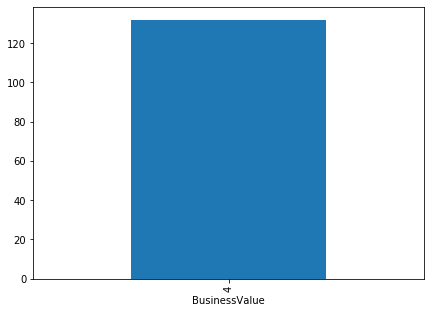

In [21]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


df_value = df.copy()
df_value = df_value[df_value['Status'] == 'open']
df_value = df_value[df_value['Type'] == 'Epic']
#df_velocity = df_velocity[df_velocity['Created'] > StartWith]
#df_velocity['Age_in_weeks'] = df_velocity['Closed'] - df_velocity['Created'] + pd.Timestamp('2020-01-01')
#df_velocity = df_velocity[['Severity', 'Age_in_weeks']]


df_vel = df_value[['BusinessValue','Risk']]
df_vel.groupby(df_vel['BusinessValue']).count().plot(figsize=(7,5), kind='bar', legend=False)


